# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data

In [2]:
train = pd.read_csv("../data/processed/SMOTE_df.csv")
validation = pd.read_csv("../data/processed/validation.csv")
test = pd.read_csv("../data/processed/test.csv")

In [3]:
y_train = train['readmitted_rescaled']
X_train = train.drop('readmitted_rescaled', axis=1)

y_val = validation['readmitted_rescaled']
X_val = validation.drop('readmitted_rescaled', axis=1)

y_test = test['readmitted_rescaled']
X_test = test.drop('readmitted_rescaled', axis=1)

In [4]:
def rename_column_names(colname):
    colname = "_".join(colname.split('-'))
    colname = "_".join(colname.split(','))
    colname = "_".join(colname.split('<'))
    colname = "_".join(colname.split('/'))
    colname = "_".join(colname.split('.'))
    colname = "_".join(colname.split('['))
    colname = "_".join(colname.split(']'))
    colname = "".join(colname.split(')'))
    colname = "_".join(colname.split('('))
    return colname
  

In [5]:
new_train_colnames = list(map(lambda x: rename_column_names(x), X_train.columns.tolist()))
new_val_colnames = list(map(lambda x: rename_column_names(x), X_val.columns.tolist()))
new_test_colnames = list(map(lambda x: rename_column_names(x), X_test.columns.tolist()))

In [6]:
X_train.columns = new_train_colnames
X_val.columns = new_val_colnames
X_test.columns = new_test_colnames

# Base Model

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalidation = xgb.DMatrix(X_val, label=y_val)

In [16]:
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
param = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [9]:
# specify validations set to watch performance
watchlist = [(dvalidation, 'eval'), (dtrain, 'train')]

In [10]:
num_round = 25
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-auc:0.574939	train-auc:0.623693
[1]	eval-auc:0.59001	train-auc:0.670517
[2]	eval-auc:0.579831	train-auc:0.708186
[3]	eval-auc:0.553883	train-auc:0.736572
[4]	eval-auc:0.543521	train-auc:0.767972
[5]	eval-auc:0.562488	train-auc:0.77669
[6]	eval-auc:0.571813	train-auc:0.786016
[7]	eval-auc:0.561704	train-auc:0.813818
[8]	eval-auc:0.567376	train-auc:0.820668
[9]	eval-auc:0.574203	train-auc:0.842267
[10]	eval-auc:0.568558	train-auc:0.868621
[11]	eval-auc:0.570229	train-auc:0.887012
[12]	eval-auc:0.568799	train-auc:0.898338
[13]	eval-auc:0.563253	train-auc:0.901407
[14]	eval-auc:0.561046	train-auc:0.904827
[15]	eval-auc:0.562571	train-auc:0.907242
[16]	eval-auc:0.563237	train-auc:0.911668
[17]	eval-auc:0.561447	train-auc:0.914021
[18]	eval-auc:0.563128	train-auc:0.916966
[19]	eval-auc:0.562175	train-auc:0.919093
[20]	eval-auc:0.563764	train-auc:0.921542
[21]	eval-auc:0.563141	train-auc:0.923222
[22]	eval-auc:0.564054	train-auc:0.924796
[23]	eval-auc:0.569048	train-auc:0.926022
[24]

## Base model performance

### Base model predictions

In [75]:
preds = bst.predict(dvalidation)
print(preds)
labels = dvalidation.get_label()
print(labels)

[0.14651231 0.29021257 0.53440356 ... 0.1798375  0.05700677 0.14533229]
[0. 1. 0. ... 0. 0. 0.]


In [82]:
print('error={:.2f}' .format(sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) /
       float(len(preds))))

error=0.13


In [87]:
bst.save_model('../models/0001.model')
# dump model
bst.dump_model('../models/0001_dump.raw.txt')
# dump model with feature map
bst.dump_model('../models/0001_dump.nice.txt')

# Hyperparameter Tuning

The first parameter we will look at is not part of the default params dictionary, but will be passed as a standalone argument to the training method. This parameter is called **"num_boost_round"** and corresponds to the number of boosting rounds or trees to build. Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter.

Tuning it together with all parameters can be done in a grid-search, but it requires a lot of computational effort.

Fortunately XGBoost provides a nice way to find the best number of rounds whilst training. Since trees are built sequentially, instead of fixing the number of rounds at the beginning, we can test our model at each step and see if adding a new tree/round improves performance.

To do so, we define a validation dataset and a metric that is used to assess performance at each round. If performance haven’t improved for N rounds (N is defined by the variable **"early_stopping_round"**), we stop the training and keep the best number of boosting rounds. 

We will pass a **"num_boost_round"** which corresponds to the maximum number of boosting rounds that we allow. We set it to a large value hoping to find the optimal number of rounds before reaching it, if we haven't improved performance on our test dataset in early_stopping_round rounds

## Number Boost Round and Early Stopping Rounds

In [8]:
# Define a default parameters to begin with as a "param" dictionary
param = {'max_depth': 6, 
         'min_child_weight': 1,
         'eta': 0.3, 
         'subsample': 1,
         'colsample_bytree': 1,
         'objective': 'binary:logistic'}

In [9]:
# Add the evaluation metric to the param dictionary
param['eval_metric'] = "auc"

# set "num_boost_rounds" to a large number
num_boost_round = 999

In [98]:
model_001 = xgb.train(param, dtrain, num_boost_round=num_boost_round, evals=[(dvalidation, "Validation")], early_stopping_rounds=10)

[0]	Validation-auc:0.54458
Will train until Validation-auc hasn't improved in 10 rounds.
[1]	Validation-auc:0.552465
[2]	Validation-auc:0.554492
[3]	Validation-auc:0.558288
[4]	Validation-auc:0.567015
[5]	Validation-auc:0.573127
[6]	Validation-auc:0.57403
[7]	Validation-auc:0.573055
[8]	Validation-auc:0.573107
[9]	Validation-auc:0.575311
[10]	Validation-auc:0.576368
[11]	Validation-auc:0.578053
[12]	Validation-auc:0.575459
[13]	Validation-auc:0.579737
[14]	Validation-auc:0.57889
[15]	Validation-auc:0.579709
[16]	Validation-auc:0.580606
[17]	Validation-auc:0.582377
[18]	Validation-auc:0.584218
[19]	Validation-auc:0.585463
[20]	Validation-auc:0.584919
[21]	Validation-auc:0.586799
[22]	Validation-auc:0.587925
[23]	Validation-auc:0.589869
[24]	Validation-auc:0.589816
[25]	Validation-auc:0.591163
[26]	Validation-auc:0.588882
[27]	Validation-auc:0.586725
[28]	Validation-auc:0.584564
[29]	Validation-auc:0.585482
[30]	Validation-auc:0.584084
[31]	Validation-auc:0.583593
[32]	Validation-auc:0.5

In [99]:
print("Best AUC: {:.2f} with {} rounds".format(
                 model_001.best_score,
                 model_001.best_iteration+1))

Best AUC: 0.59 with 26 rounds


The training stopped before reaching the maximum number of boosting rounds (999), that’s because after the 26th tree, adding more rounds did not lead to improvements of AUC on the validation dataset.

The AUC is 0.59 with default parameters and an optimal number of boosting rounds, on the validation dataset.

# Using XGBoost’s CV

In order to tune the other hyperparameters, we will use the cv function from XGBoost. It allows us to run cross-validation on our training dataset and returns a mean AUC score.

We need to pass it:
* **params**: our dictionary of parameters.

* **our dtrain matrix**.

* **num_boost_round**: number of boosting rounds. We will use a large number again and count on **early_stopping_rounds** to find the optimal number of rounds before reaching the maximum.

* **seed**: random seed. It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.

* **nfold**: the number of folds to use for cross-validation

* **metrics**: the metrics to use to evaluate our model, here we use **AUC**.

There is no need to pass a test dataset here. It’s because the cross-validation function is splitting the train dataset into nfolds and iteratively keeps one of the folds for test purposes. 

## Cross validation score with default parameters

In [107]:
cv_results = xgb.cv(param,
                    dtrain,
                    num_boost_round=num_boost_round,
                    seed=42,
                    nfold=5,
                    metrics={"auc"},
                    early_stopping_rounds=10)
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.623693,0.000864,0.623666,0.003424
1,0.670518,0.000914,0.670510,0.003660
2,0.708491,0.000616,0.708416,0.004882
3,0.737613,0.000677,0.737446,0.007267
4,0.768219,0.000864,0.768418,0.005216
...,...,...,...,...
125,0.959062,0.002151,0.955588,0.001537
126,0.959073,0.002123,0.955649,0.001500
127,0.959115,0.002123,0.955695,0.001516
128,0.959163,0.002164,0.955745,0.001510


In [111]:
print("Test-AUC-Mean {}".format(cv_results["test-auc-mean"].max()))

Test-AUC-Mean 0.9557624


## max_depth and min_child_weight

These parameters add constraints on the architecture of the trees and prevent overfitting. Tuning these parameters find a good trade-off between model bias and variance.

**max_depth** - is the maximum number of nodes allowed from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but as we go deeper, splits become less relevant and are sometimes only due to noise, causing the model to overfit.

**min_child_weight** -  is the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree. A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples, thus allowing for more complex trees, but again, more likely to overfit.

In [120]:
# Define a grid for these two parameters
param_grid = [(max_depth, min_child_weight)
              for max_depth in range(9, 12) for min_child_weight in range(5,8)]

In [123]:
# Define initial best params and AUC
max_auc = float("-Inf")
best_params = None

for max_depth, min_child_weight in tqdm(param_grid):
    print("CV with max_depth = {} and min_child_weight = {}".format(
        max_depth, min_child_weight))
    
    # Update our parameters
    param['max_depth'] = max_depth
    param['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(param,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=3,
                        metrics={"auc"},
                        early_stopping_rounds=10,
                        as_pandas=True)
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (max_depth, min_child_weight)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

  0%|          | 0/9 [00:00<?, ?it/s]

CV with max_depth = 9 and min_child_weight = 5


 11%|█         | 1/9 [03:54<31:15, 234.38s/it]

	AUC 0.9599016666666667 for 29 rounds
CV with max_depth = 9 and min_child_weight = 6


 22%|██▏       | 2/9 [08:05<27:54, 239.25s/it]

	AUC 0.959372 for 35 rounds
CV with max_depth = 9 and min_child_weight = 7


 33%|███▎      | 3/9 [12:14<24:14, 242.45s/it]

	AUC 0.9602056666666666 for 32 rounds
CV with max_depth = 10 and min_child_weight = 5


 44%|████▍     | 4/9 [16:31<20:32, 246.56s/it]

	AUC 0.960337 for 28 rounds
CV with max_depth = 10 and min_child_weight = 6


 56%|█████▌    | 5/9 [21:30<17:29, 262.50s/it]

	AUC 0.9589059999999999 for 32 rounds
CV with max_depth = 10 and min_child_weight = 7


 67%|██████▋   | 6/9 [25:18<12:36, 252.01s/it]

	AUC 0.9600673333333334 for 25 rounds
CV with max_depth = 11 and min_child_weight = 5


 78%|███████▊  | 7/9 [29:48<08:34, 257.45s/it]

	AUC 0.9604739999999999 for 31 rounds
CV with max_depth = 11 and min_child_weight = 6


 89%|████████▉ | 8/9 [32:54<03:55, 235.96s/it]

	AUC 0.9604316666666666 for 18 rounds
CV with max_depth = 11 and min_child_weight = 7


100%|██████████| 9/9 [36:29<00:00, 243.29s/it]

	AUC 0.960932 for 23 rounds
Best params: 11, 7, AUC: 0.960932


We get the best score with a max_depth of 11 and min_child_weight of 7, so let's update our param dict:

In [10]:
param['max_depth'] = 11
param['min_child_weight'] = 7

## Subsample and Colsample_bytrees

These parameters control the sampling of the dataset that is done at each boosting round.

Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.

**subsample** corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows.
**colsample_bytree** corresponds to the fraction of features (the columns) to use. By default it is set to 1 meaning that we will use all features.

In [129]:
[i/10. for i in range(7, 11)]

[0.7, 0.8, 0.9, 1.0]

In [130]:
param_grid = [(subsample, colsample)
              for subsample in [i/10. for i in range(7, 11)]
              for colsample in [i/10. for i in range(7, 11)]]

In [131]:
# Define initial best params and AUC
max_auc = float("-Inf")
best_params = None


# iterate over the sample space
for subsample, colsample in tqdm(param_grid ):
    print("CV with subsample = {} and colsample = {}".format(
        subsample, colsample))
    
    # Update our parameters
    param['subsample'] = subsample
    param['colsample_bytree'] = colsample
    
    # Run CV
    cv_results = xgb.cv(param,
                        dtrain,
                        num_boost_round=num_boost_round,
                        seed=42,
                        nfold=3,
                        metrics={"auc"},
                        early_stopping_rounds=10,
                        as_pandas=True)
    # Update best MAE
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds".format(mean_auc, boost_rounds))
    if mean_auc > max_auc:
        max_auc = mean_auc
        best_params = (subsample, colsample)
print("Best params: {}, {}, AUC: {}".format(best_params[0], best_params[1], max_auc))

  0%|          | 0/16 [00:00<?, ?it/s]

CV with subsample = 0.7 and colsample = 0.7


  6%|▋         | 1/16 [09:12<2:18:09, 552.62s/it]

	AUC 0.9581206666666667 for 31 rounds
CV with subsample = 0.7 and colsample = 0.8


 12%|█▎        | 2/16 [14:31<1:52:33, 482.41s/it]

	AUC 0.9592156666666667 for 32 rounds
CV with subsample = 0.7 and colsample = 0.9


 19%|█▉        | 3/16 [18:14<1:27:41, 404.69s/it]

	AUC 0.9589196666666666 for 17 rounds
CV with subsample = 0.7 and colsample = 1.0


 25%|██▌       | 4/16 [22:02<1:10:18, 351.52s/it]

	AUC 0.9596766666666667 for 18 rounds
CV with subsample = 0.8 and colsample = 0.7


 31%|███▏      | 5/16 [26:46<1:00:44, 331.32s/it]

	AUC 0.959078 for 27 rounds
CV with subsample = 0.8 and colsample = 0.8


 38%|███▊      | 6/16 [32:03<54:30, 327.06s/it]  

	AUC 0.9593223333333333 for 32 rounds
CV with subsample = 0.8 and colsample = 0.9


 44%|████▍     | 7/16 [35:45<44:21, 295.74s/it]

	AUC 0.959512 for 18 rounds
CV with subsample = 0.8 and colsample = 1.0


 50%|█████     | 8/16 [39:49<37:21, 280.22s/it]

	AUC 0.9599773333333333 for 20 rounds
CV with subsample = 0.9 and colsample = 0.7


 56%|█████▋    | 9/16 [43:08<29:50, 255.78s/it]

	AUC 0.9595546666666667 for 25 rounds
CV with subsample = 0.9 and colsample = 0.8


 62%|██████▎   | 10/16 [46:47<24:28, 244.76s/it]

	AUC 0.959197 for 25 rounds
CV with subsample = 0.9 and colsample = 0.9


 69%|██████▉   | 11/16 [50:23<19:39, 235.97s/it]

	AUC 0.9601259999999999 for 22 rounds
CV with subsample = 0.9 and colsample = 1.0


 75%|███████▌  | 12/16 [56:26<18:16, 274.11s/it]

	AUC 0.9605743333333333 for 26 rounds
CV with subsample = 1.0 and colsample = 0.7


 81%|████████▏ | 13/16 [1:00:18<13:04, 261.65s/it]

	AUC 0.9599286666666668 for 28 rounds
CV with subsample = 1.0 and colsample = 0.8


 88%|████████▊ | 14/16 [1:03:37<08:05, 242.63s/it]

	AUC 0.9595053333333334 for 24 rounds
CV with subsample = 1.0 and colsample = 0.9


 94%|█████████▍| 15/16 [1:07:14<03:54, 235.00s/it]

	AUC 0.959482 for 20 rounds
CV with subsample = 1.0 and colsample = 1.0


100%|██████████| 16/16 [1:11:05<00:00, 266.62s/it]

	AUC 0.960932 for 23 rounds
Best params: 1.0, 1.0, AUC: 0.960932


In [11]:
param['subsample'] = 1.
param['colsample_bytree'] = 1.

## ETA

The ETA parameter controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round, in other words it defines the amount of "correction" we make at each step
In practice, having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best. But with a lower eta, we need more boosting rounds, which takes more time to train, sometimes for only marginal improvements. Let's try a couple of values here, and time them with the notebook command:bbb

In [18]:
# Define initial best params and AUC
max_auc = float("-Inf")
best_params = None


for eta in tqdm([.3, .2, .1, .05, .01, .005]):
    print("CV with eta={}".format(eta))
    # We update our parameters
    param['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
        param,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={"auc"},
        early_stopping_rounds=10
    )
    # Update best score
    mean_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds\n".format(mean_auc, boost_rounds))
    if mean_auc < max_auc:
        max_auc = mean_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc))

  0%|          | 0/6 [00:00<?, ?it/s]

CV with eta=0.3
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


 17%|█▋        | 1/6 [10:29<52:26, 629.36s/it]

	AUC 0.9644202 for 43 rounds

CV with eta=0.2
CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


 33%|███▎      | 2/6 [2:25:46<3:11:42, 2875.72s/it]

	AUC 0.9649552 for 58 rounds

CV with eta=0.1
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


 50%|█████     | 3/6 [3:47:39<2:54:20, 3486.82s/it]

	AUC 0.9655692 for 109 rounds

CV with eta=0.05
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


 67%|██████▋   | 4/6 [5:32:17<2:24:08, 4324.10s/it]

	AUC 0.9653751999999999 for 184 rounds

CV with eta=0.01
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


 83%|████████▎ | 5/6 [10:03:13<2:11:43, 7903.95s/it]

	AUC 0.96549 for 996 rounds

CV with eta=0.005
CPU times: user 4 µs, sys: 7 µs, total: 11 µs
Wall time: 29.8 µs


100%|██████████| 6/6 [25:32:58<00:00, 15329.70s/it] 

	AUC 0.9642986 for 998 rounds

Best params: None, AUC: -inf


In [12]:
param['eta'] = 0.1

## Tuning Results Hyperparameters

In [13]:
param

{'max_depth': 11,
 'min_child_weight': 7,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'binary:logistic',
 'eval_metric': 'auc'}

# Final Model

In [17]:
best_model = xgb.train(
    param,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dvalidation, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.553303
Will train until Validation-auc hasn't improved in 20 rounds.
[1]	Validation-auc:0.557079
[2]	Validation-auc:0.559656
[3]	Validation-auc:0.562852
[4]	Validation-auc:0.562811
[5]	Validation-auc:0.562513
[6]	Validation-auc:0.562838
[7]	Validation-auc:0.564833
[8]	Validation-auc:0.564798
[9]	Validation-auc:0.567778
[10]	Validation-auc:0.566211
[11]	Validation-auc:0.566508
[12]	Validation-auc:0.567766
[13]	Validation-auc:0.569518
[14]	Validation-auc:0.570784
[15]	Validation-auc:0.571355
[16]	Validation-auc:0.572737
[17]	Validation-auc:0.574034
[18]	Validation-auc:0.574788
[19]	Validation-auc:0.575801
[20]	Validation-auc:0.576442
[21]	Validation-auc:0.5771
[22]	Validation-auc:0.577161
[23]	Validation-auc:0.577532
[24]	Validation-auc:0.577915
[25]	Validation-auc:0.578445
[26]	Validation-auc:0.577873
[27]	Validation-auc:0.58054
[28]	Validation-auc:0.581033
[29]	Validation-auc:0.580472
[30]	Validation-auc:0.580667
[31]	Validation-auc:0.580733
[32]	Validation-auc:0.5

Text(0.5, 0, 'Score')

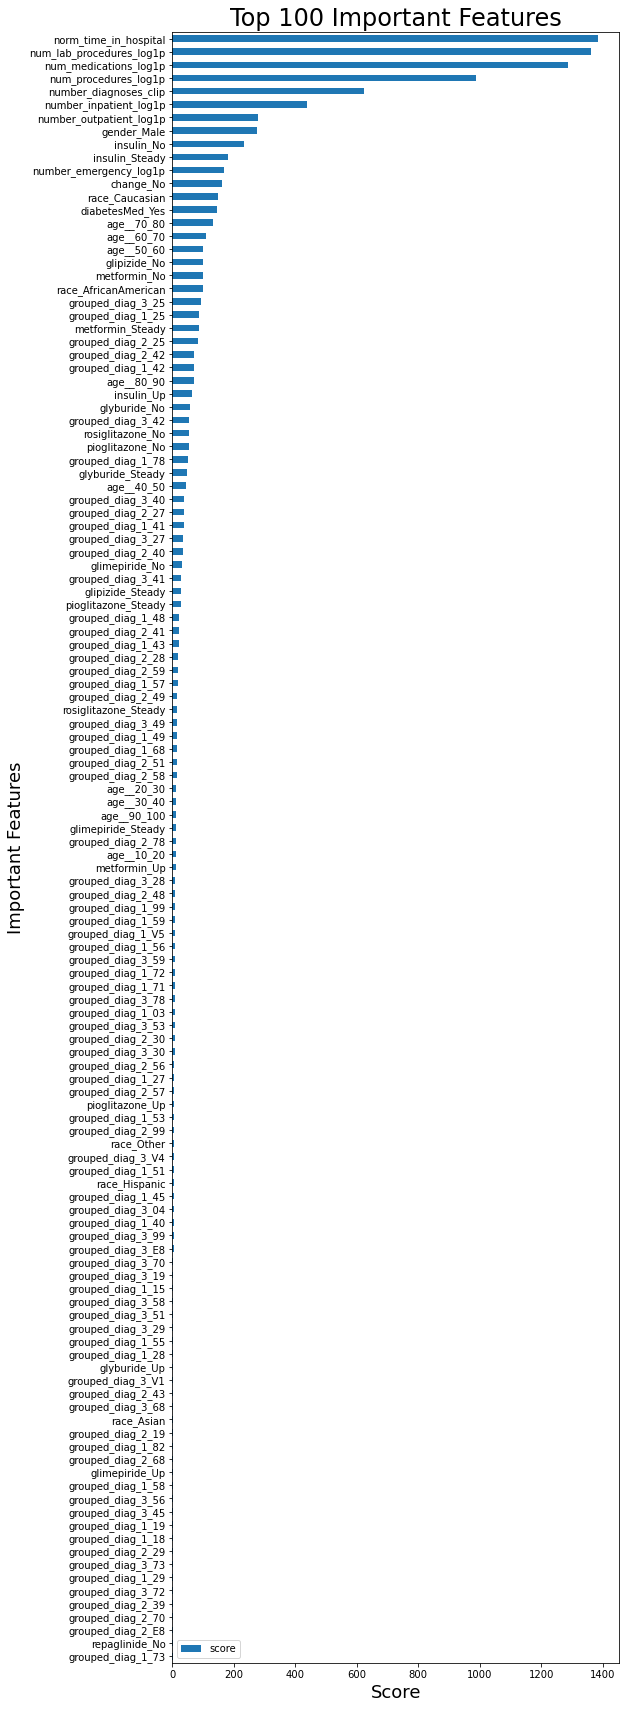

In [19]:
feature_important = best_model.get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

feature_importance_df = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
fig, ax = plt.subplots(figsize=(8,30))
feature_importance_df.plot(kind='barh', ax=ax)
ax.set_title("Top 100 Important Features", fontsize=24)
ax.set_ylabel("Important Features", fontsize=18)
ax.set_xlabel("Score", fontsize=18)

In [22]:
fig.savefig("../reports/figures/best_model_001.png")

# Model tuning and feature selection

In [40]:
imp_features = feature_importance_df.sort_values(by='score', ascending=False).index.tolist()
print(len(imp_features))

# 25 features
top_25_features = imp_features[:25]

# 50 features
top_50_features = imp_features[:50]

# 75 features
top_75_features = imp_features[:75]

# 100 features
top_100_features = imp_features[:100]


124


## dTrain and dValidation Matrices with top features

In [41]:
dtrain_25 = xgb.DMatrix(X_train[top_25_features], label=y_train)
dtrain_50 = xgb.DMatrix(X_train[top_50_features], label=y_train)
dtrain_75 = xgb.DMatrix(X_train[top_75_features], label=y_train)
dtrain_100 = xgb.DMatrix(X_train[top_100_features], label=y_train)

In [45]:
dvalidation_25 = xgb.DMatrix(X_val[top_25_features], label=y_val)
dvalidation_50 = xgb.DMatrix(X_val[top_50_features], label=y_val)
dvalidation_75 = xgb.DMatrix(X_val[top_75_features], label=y_val)
dvalidation_100 = xgb.DMatrix(X_val[top_100_features], label=y_val)

## Model with top 25 features

In [44]:
best_model_25 = xgb.train(
    param,
    dtrain_25,
    num_boost_round=num_boost_round,
    evals=[(dvalidation_25, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.548398
Will train until Validation-auc hasn't improved in 20 rounds.
[1]	Validation-auc:0.551653
[2]	Validation-auc:0.551904
[3]	Validation-auc:0.553974
[4]	Validation-auc:0.556176
[5]	Validation-auc:0.558215
[6]	Validation-auc:0.558901
[7]	Validation-auc:0.559239
[8]	Validation-auc:0.559218
[9]	Validation-auc:0.559561
[10]	Validation-auc:0.561212
[11]	Validation-auc:0.560576
[12]	Validation-auc:0.560817
[13]	Validation-auc:0.560216
[14]	Validation-auc:0.562501
[15]	Validation-auc:0.563336
[16]	Validation-auc:0.562576
[17]	Validation-auc:0.563367
[18]	Validation-auc:0.563556
[19]	Validation-auc:0.562912
[20]	Validation-auc:0.562087
[21]	Validation-auc:0.562996
[22]	Validation-auc:0.562931
[23]	Validation-auc:0.563728
[24]	Validation-auc:0.562726
[25]	Validation-auc:0.562685
[26]	Validation-auc:0.56254
[27]	Validation-auc:0.563585
[28]	Validation-auc:0.563288
[29]	Validation-auc:0.564171
[30]	Validation-auc:0.564043
[31]	Validation-auc:0.564028
[32]	Validation-auc:0

## Model with top 50 features

In [46]:
best_model_50 = xgb.train(
    param,
    dtrain_50,
    num_boost_round=num_boost_round,
    evals=[(dvalidation_50, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.553215
Will train until Validation-auc hasn't improved in 20 rounds.
[1]	Validation-auc:0.556527
[2]	Validation-auc:0.558485
[3]	Validation-auc:0.560965
[4]	Validation-auc:0.561329
[5]	Validation-auc:0.561591
[6]	Validation-auc:0.561524
[7]	Validation-auc:0.562945
[8]	Validation-auc:0.562657
[9]	Validation-auc:0.562679
[10]	Validation-auc:0.561978
[11]	Validation-auc:0.563413
[12]	Validation-auc:0.565076
[13]	Validation-auc:0.565786
[14]	Validation-auc:0.567053
[15]	Validation-auc:0.567599
[16]	Validation-auc:0.569706
[17]	Validation-auc:0.570104
[18]	Validation-auc:0.569876
[19]	Validation-auc:0.569924
[20]	Validation-auc:0.570847
[21]	Validation-auc:0.56969
[22]	Validation-auc:0.568164
[23]	Validation-auc:0.570112
[24]	Validation-auc:0.56972
[25]	Validation-auc:0.568988
[26]	Validation-auc:0.568772
[27]	Validation-auc:0.56933
[28]	Validation-auc:0.569674
[29]	Validation-auc:0.569896
[30]	Validation-auc:0.571711
[31]	Validation-auc:0.571019
[32]	Validation-auc:0.5

## Model with top 75 features

In [47]:
best_model_75 = xgb.train(
    param,
    dtrain_75,
    num_boost_round=num_boost_round,
    evals=[(dvalidation_75, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.553543
Will train until Validation-auc hasn't improved in 20 rounds.
[1]	Validation-auc:0.557081
[2]	Validation-auc:0.5591
[3]	Validation-auc:0.562156
[4]	Validation-auc:0.562515
[5]	Validation-auc:0.562192
[6]	Validation-auc:0.56255
[7]	Validation-auc:0.564559
[8]	Validation-auc:0.564478
[9]	Validation-auc:0.56714
[10]	Validation-auc:0.565558
[11]	Validation-auc:0.565312
[12]	Validation-auc:0.567538
[13]	Validation-auc:0.569534
[14]	Validation-auc:0.56869
[15]	Validation-auc:0.569974
[16]	Validation-auc:0.570482
[17]	Validation-auc:0.57211
[18]	Validation-auc:0.571988
[19]	Validation-auc:0.573226
[20]	Validation-auc:0.575693
[21]	Validation-auc:0.579168
[22]	Validation-auc:0.5797
[23]	Validation-auc:0.58069
[24]	Validation-auc:0.581468
[25]	Validation-auc:0.582601
[26]	Validation-auc:0.581878
[27]	Validation-auc:0.581801
[28]	Validation-auc:0.582639
[29]	Validation-auc:0.582314
[30]	Validation-auc:0.583479
[31]	Validation-auc:0.584123
[32]	Validation-auc:0.584671


## Model with top 100 features

In [48]:
best_model_100 = xgb.train(
    param,
    dtrain_100,
    num_boost_round=num_boost_round,
    evals=[(dvalidation_100, "Validation")],
    early_stopping_rounds=20)

[0]	Validation-auc:0.553543
Will train until Validation-auc hasn't improved in 20 rounds.
[1]	Validation-auc:0.557081
[2]	Validation-auc:0.559659
[3]	Validation-auc:0.562625
[4]	Validation-auc:0.562813
[5]	Validation-auc:0.562514
[6]	Validation-auc:0.562839
[7]	Validation-auc:0.564833
[8]	Validation-auc:0.5648
[9]	Validation-auc:0.567803
[10]	Validation-auc:0.56623
[11]	Validation-auc:0.566518
[12]	Validation-auc:0.567766
[13]	Validation-auc:0.569518
[14]	Validation-auc:0.570784
[15]	Validation-auc:0.571374
[16]	Validation-auc:0.572741
[17]	Validation-auc:0.574045
[18]	Validation-auc:0.573415
[19]	Validation-auc:0.57438
[20]	Validation-auc:0.574971
[21]	Validation-auc:0.574608
[22]	Validation-auc:0.575552
[23]	Validation-auc:0.576395
[24]	Validation-auc:0.576879
[25]	Validation-auc:0.577512
[26]	Validation-auc:0.577857
[27]	Validation-auc:0.578309
[28]	Validation-auc:0.578531
[29]	Validation-auc:0.580496
[30]	Validation-auc:0.582079
[31]	Validation-auc:0.583124
[32]	Validation-auc:0.58

In [51]:
feature_importance_df.to_csv("../reports/feature_importances.csv", index=False)

# Save Models

In [49]:
best_model.save_model("../models/best_model_001.model")
best_model_25.save_model("../models/best_model_25.model")
best_model_50.save_model("../models/best_model_50.model")
best_model_75.save_model("../models/best_model_75.model")
best_model_100.save_model("../models/best_model_100.model")

In [50]:
loaded_model = xgb.Booster()
loaded_model.load_model("../models/best_model_001.model")
loaded_model.load_model("../models/best_model_25.model")
loaded_model.load_model("../models/best_model_50.model")
loaded_model.load_model("../models/best_model_75.model")
loaded_model.load_model("../models/best_model_100.model")
